## Workforce Scheduling

### A *Mod*ern Story

- Data scientist with PyData stack experience
- Available historical data for customer demand
- Can build predictions of staffing requirements
- I'm not confident formulating LPs and MIPs

**-> How do I move from predictive to prescriptive analytics?**

In [5]:
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt

### Grab some historical data

Helps me build a picture of customer demand (easy)

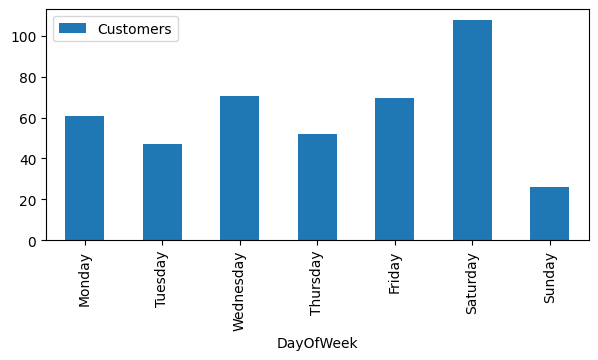

In [6]:
engine = sqlalchemy.create_engine("sqlite:///data/customer-data.db")
with engine.connect() as con:
    history = pd.read_sql("select Date, Customers from history", con)

daily_averages = (
    history.assign(
        Date=lambda df: pd.to_datetime(df["Date"]),
        DayOfWeekIndex=lambda df: df["Date"].dt.dayofweek,
        DayOfWeek=lambda df: df["Date"].dt.day_name(),
    )
    .groupby(["DayOfWeekIndex", "DayOfWeek"])["Customers"].mean()
    .reset_index()
)
fig, ax = plt.subplots(1, 1, figsize=(7,3))
daily_averages.plot.bar(x="DayOfWeek", y="Customers", ax=ax);

### Predictive Modeling

I know how many staff I need per customer, so staff requirements are easy:

In [7]:
daily_staff = daily_averages.assign(
    StaffRequired=lambda df: df["Customers"].div(20).round().astype(int)
)
daily_staff

,DayOfWeekIndex,DayOfWeek,Customers,StaffRequired
0,0,Monday,60.769231,3
1,1,Tuesday,46.846154,2
2,2,Wednesday,70.653846,4
3,3,Thursday,52.173077,3
4,4,Friday,69.769231,3
5,5,Saturday,107.660377,5
6,6,Sunday,26.038462,1


I need to plan shifts for the next month, I'll extrapolate from this data:

In [8]:
upcoming_shifts = (
    pd.date_range(
        start=pd.Timestamp("2023-06-01"),
        periods=30,
        freq="D",
    )
    .to_frame(name="Date", index=False)
    .assign(DayOfWeekIndex=lambda df: df["Date"].dt.dayofweek)
    .join(daily_staff.set_index("DayOfWeekIndex")["StaffRequired"], on="DayOfWeekIndex")
    .drop(columns="DayOfWeekIndex")
)
upcoming_shifts.head()

,Date,StaffRequired
0,2023-06-01,3
1,2023-06-02,3
2,2023-06-03,5
3,2023-06-04,1
4,2023-06-05,3


### Human Info

My staff told me their availability on various days:

In [9]:
staff_availability = pd.read_excel("data/staff-availability.xlsx")
staff_availability.head()

,Date,Bradley,Christian,Christopher,Deborah,Deidra,Eloy,Maria,Natalie,Susie,Terry
0,2023-06-01,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes
1,2023-06-02,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No
2,2023-06-03,Yes,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes
3,2023-06-04,No,No,No,Yes,Yes,Yes,Yes,No,No,No
4,2023-06-05,Yes,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes


### What now?

1. Go back to said excel sheet, start assigning people at random
2. Google "how to create a shift roster"
    - Result is not technical enough: watch many youtube videos, tutorials that tell you how to put data into excel, a site explaining how to use Microsoft shifts
3. Google "shift scheduling in python"
    - Currently find some articles on mathematical programming in quite a lot of detail

### Find the right OptiMod!

In [10]:
# Do a little reading, install the package, try the example ...

from gurobi_optimods.datasets import load_workforce
from gurobi_optimods.workforce import solve_workforce_scheduling

# Load example data
data = load_workforce()

# Solve the Mod, get back a schedule
assigned_shifts = solve_workforce_scheduling(
    availability=data.availability,
    shift_requirements=data.shift_requirements,
    worker_limits=data.worker_limits,
    preferences="Preference",
)

Restricted license - for non-production use only - expires 2024-10-28
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 28 rows, 72 columns and 216 nonzeros
Model fingerprint: 0xf3d4e6ad
Variable types: 0 continuous, 72 integer (72 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 5e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 8e+00]
Found heuristic solution: objective 170.0000000
Presolve removed 6 rows and 22 columns
Presolve time: 0.00s
Presolved: 22 rows, 50 columns, 145 nonzeros
Variable types: 0 continuous, 50 integer (50 binary)
Found heuristic solution: objective 177.0000000

Root relaxation: objective 1.850000e+02, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

### Munge data

A little pandas manipulation is needed to meet the Mod requirements

In [12]:
availability = (
    staff_availability.set_index("Date").stack().reset_index()
    .rename(columns={"level_1": "Worker", "Date": "Shift", 0: "Available"})
    .query("Available == 'Yes'")
    .drop(columns=["Available"])
)
availability.head()

,Shift,Worker
0,2023-06-01,Bradley
1,2023-06-01,Christian
3,2023-06-01,Deborah
4,2023-06-01,Deidra
5,2023-06-01,Eloy


In [13]:
shift_requirements = upcoming_shifts.rename(
    columns={"Date": "Shift", "StaffRequired": "Required"}
)
shift_requirements.head()

,Shift,Required
0,2023-06-01,3
1,2023-06-02,3
2,2023-06-03,5
3,2023-06-04,1
4,2023-06-05,3


In [14]:
worker_limits = pd.DataFrame({
    "Worker": availability["Worker"].unique(),
    "MinShifts": 5,
    "MaxShifts": 10,
})
worker_limits.head()

,Worker,MinShifts,MaxShifts
0,Bradley,5,10
1,Christian,5,10
2,Deborah,5,10
3,Deidra,5,10
4,Eloy,5,10


### Solve it

- This should be as simple as copy-paste
- Note: no `Model`, no variables, no constraints (no maths)

In [16]:
# --- solve for your inputs ---

from gurobi_optimods.workforce import solve_workforce_scheduling

# Solve the Mod, get back a schedule
assigned_shifts = solve_workforce_scheduling(
    availability=availability,
    shift_requirements=shift_requirements,
    worker_limits=worker_limits,
    verbose=False,
)
assigned_shifts

,Worker,Shift
0,Bradley,2023-06-01
1,Deidra,2023-06-01
2,Susie,2023-06-01
3,Deidra,2023-06-02
4,Eloy,2023-06-02
...,...,...
85,Eloy,2023-06-29
86,Terry,2023-06-29
87,Deborah,2023-06-30
88,Deidra,2023-06-30


In [18]:
# --- inspect the results ---
shift_requirements.head()

,Shift,Required
0,2023-06-01,3
1,2023-06-02,3
2,2023-06-03,5
3,2023-06-04,1
4,2023-06-05,3


In [20]:
assigned_shifts.groupby("Shift").count().head()

,Worker
Shift,
2023-06-01,3
2023-06-02,3
2023-06-03,5
2023-06-04,1
2023-06-05,3


In [21]:
shifts_table = pd.pivot_table(
    assigned_shifts.assign(value=1),
    values="value",
    index="Shift",
    columns="Worker",
    fill_value="-",
).replace({1.0: "Y"})
shifts_table

Worker,Bradley,Christian,Christopher,Deborah,Deidra,Eloy,Maria,Natalie,Susie,Terry
Shift,,,,,,,,,,
2023-06-01,Y,-,-,-,Y,-,-,-,Y,-
2023-06-02,-,-,-,-,Y,Y,-,Y,-,-
2023-06-03,Y,Y,-,-,-,-,Y,-,Y,Y
2023-06-04,-,-,-,-,-,-,Y,-,-,-
2023-06-05,-,-,-,Y,-,-,-,Y,-,Y
2023-06-06,Y,-,-,-,-,-,-,Y,-,-
2023-06-07,-,Y,-,-,Y,-,-,Y,Y,-
2023-06-08,-,Y,-,Y,-,-,-,-,Y,-
2023-06-09,-,-,Y,Y,-,-,Y,-,-,-


### Done!

- My scheduling problems are solved
- There are more requirements I could incorporate (see docs)
- I can delve into the details (if I want to)